This script is designed to quantify similarities and differences between two aspects of the visual pathway in object recognition.

## DICE COEEFICIENT 

In [1]:
# calculate dice coefficient between pIPS and LO FC maps
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image
import matplotlib.pyplot as plt

# Define study directories
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
group_out_dir = f'{results_dir}/group_averages'

def dice_coefficient(img1, img2):
    """Calculate Dice coefficient between two binary images."""
    # Get data arrays and ensure binary
    img1_data = (img1.get_fdata() > 0).astype(int)
    img2_data = (img2.get_fdata() > 0).astype(int)
    
    # Calculate intersection
    intersection = np.sum(img1_data * img2_data)
    
    # Calculate Dice using standard formula: 2*intersection/(sum of elements)
    dice = 2.0 * intersection / (np.sum(img1_data) + np.sum(img2_data))
    
    return dice

def main():
    # Define ROIs and hemispheres
    rois = ['pIPS', 'LO']
    hemispheres = ['left', 'right']
    analysis_type = 'fc'  # Using fc as specified in your goal
    
    # Create a results table
    results = []
    
    # Compare across hemispheres
    for hemi in hemispheres:
        # Load images
        pips_img_path = f'{group_out_dir}/pIPS_{hemi}_{analysis_type}_thresh.nii.gz'
        lo_img_path = f'{group_out_dir}/LO_{hemi}_{analysis_type}_thresh.nii.gz'
        
        # Check if files exist
        if not os.path.exists(pips_img_path):
            print(f"Warning: File not found - {pips_img_path}")
            continue
            
        if not os.path.exists(lo_img_path):
            print(f"Warning: File not found - {lo_img_path}")
            continue
            
        # Both files exist, proceed with analysis
        pips_img = nib.load(pips_img_path)
        lo_img = nib.load(lo_img_path)
        
        # Calculate Dice coefficient
        dice_score = dice_coefficient(pips_img, lo_img)
        
        results.append({
            'Hemisphere': hemi,
            'ROI1': 'pIPS',
            'ROI2': 'LO',
            'Dice': dice_score
        })
        
        print(f"Dice coefficient for {hemi} hemisphere, pIPS vs LO: {dice_score:.4f}")
    
    # Check if we have any results
    if not results:
        print("No results were calculated. Please check if the input files exist.")
        return None
    
    # Convert results to DataFrame for easy viewing
    results_df = pd.DataFrame(results)
    print("\nResults summary:")
    print(results_df)
    
    # Create a simple bar plot of results
    plt.figure(figsize=(8, 6))
    bars = plt.bar(
        [f"{r['Hemisphere']} hemisphere" for r in results],
        [r['Dice'] for r in results]
    )
    plt.title('Dice Coefficient Between pIPS and LO FC Maps')
    plt.ylabel('Dice Coefficient')
    plt.ylim(0, 1)  # Dice coef ranges from 0-1
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height + 0.01,
            f'{height:.4f}',
            ha='center', va='bottom'
        )
    
    # Save plot
    plot_path = f'{results_dir}/pIPS_LO_dice_comparison.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"Saved plot to: {plot_path}")
    plt.close()
    
    return results_df

if __name__ == "__main__":
    results = main()

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Dice coefficient for left hemisphere, pIPS vs LO: 0.6965
Dice coefficient for right hemisphere, pIPS vs LO: 0.6930

Results summary:
  Hemisphere  ROI1 ROI2      Dice
0       left  pIPS   LO  0.696452
1      right  pIPS   LO  0.692965
Saved plot to: /user_data/csimmon2/git_repos/ptoc/results/pIPS_LO_dice_comparison.png



ANALYSIS TYPE: FC

Left hemisphere analysis (fc):
Dice coefficient: 0.6965
pIPS only: 13341 voxels (32.4%)
LO only: 5832 voxels (14.2%)
Overlap: 21995 voxels (53.4%)

Right hemisphere analysis (fc):
Dice coefficient: 0.6930
pIPS only: 13908 voxels (34.6%)
LO only: 4982 voxels (12.4%)
Overlap: 21317 voxels (53.0%)

ANALYSIS TYPE: PPI

Left hemisphere analysis (ppi):
Dice coefficient: 0.7870
pIPS only: 2406 voxels (13.1%)
LO only: 4051 voxels (22.0%)
Overlap: 11926 voxels (64.9%)

Right hemisphere analysis (ppi):
Dice coefficient: 0.7056
pIPS only: 7619 voxels (31.9%)
LO only: 3248 voxels (13.6%)
Overlap: 13025 voxels (54.5%)

FC Results summary:
  Analysis Hemisphere      Dice  pIPS_only  LO_only  Overlap  Total  \
0       fc       left  0.696452      13341     5832    21995  41168   
1       fc      right  0.692965      13908     4982    21317  40207   

   pIPS_only_pct  LO_only_pct  Overlap_pct  
0      32.406238    14.166343    53.427419  
1      34.590992    12.390877    53.018131

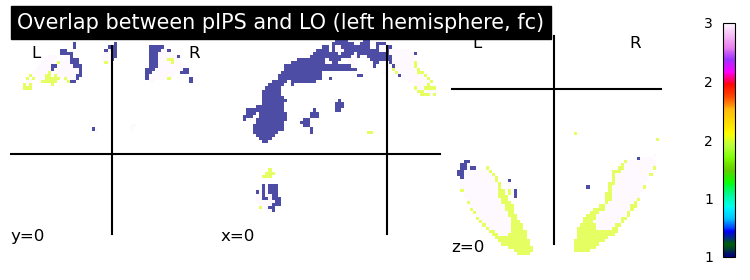

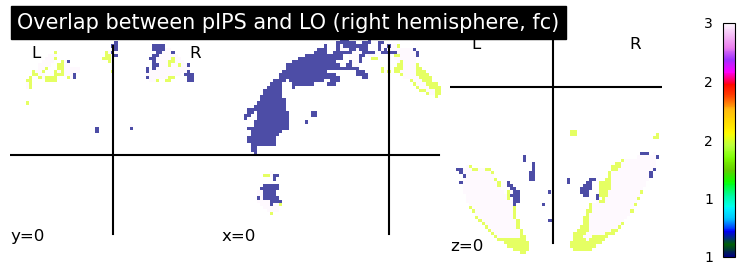

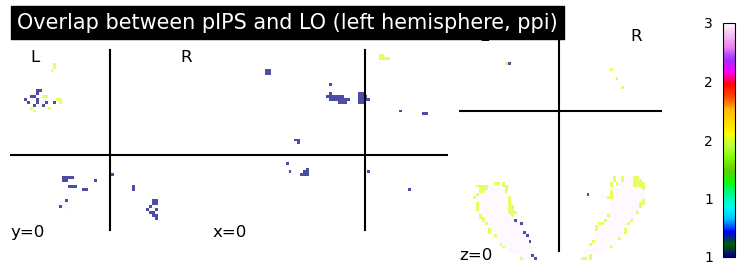

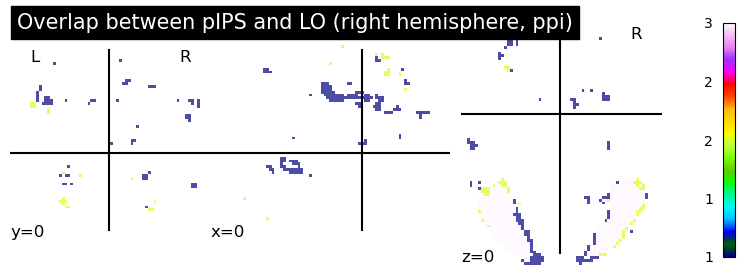

In [7]:
# Break down the overlap between pIPS and LO for review of results
## add PPI
import os
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn import plotting

# Define study directories
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
group_out_dir = f'{results_dir}/group_averages'

def dice_coefficient(img1, img2):
    """Calculate Dice coefficient between two binary images."""
    # Get data arrays and ensure binary
    img1_data = (img1.get_fdata() > 0).astype(int)
    img2_data = (img2.get_fdata() > 0).astype(int)
    
    # Calculate intersection
    intersection = np.sum(img1_data * img2_data)
    
    # Calculate Dice using standard formula: 2*intersection/(sum of elements)
    dice = 2.0 * intersection / (np.sum(img1_data) + np.sum(img2_data))
    
    return dice, img1_data, img2_data

def main():
    # Define hemispheres and analysis types
    hemispheres = ['left', 'right']
    analysis_types = ['fc', 'ppi']
    
    # Create results tables
    results = []
    
    # Loop through analysis types
    for analysis_type in analysis_types:
        print(f"\n{'='*50}")
        print(f"ANALYSIS TYPE: {analysis_type.upper()}")
        print(f"{'='*50}")
        
        # Compare across hemispheres
        for hemi in hemispheres:
            # Load images
            pips_img_path = f'{group_out_dir}/pIPS_{hemi}_{analysis_type}_thresh.nii.gz'
            lo_img_path = f'{group_out_dir}/LO_{hemi}_{analysis_type}_thresh.nii.gz'
            
            # Check if files exist
            if not os.path.exists(pips_img_path) or not os.path.exists(lo_img_path):
                print(f"Warning: Files not found for {hemi} hemisphere, {analysis_type}. Skipping.")
                continue
                
            # Load images
            pips_img = nib.load(pips_img_path)
            lo_img = nib.load(lo_img_path)
            
            # Calculate Dice coefficient
            dice_score, pips_data, lo_data = dice_coefficient(pips_img, lo_img)
            
            # Create overlap map (1=pIPS only, 2=LO only, 3=overlap)
            overlap_data = np.zeros_like(pips_data)
            overlap_data[pips_data == 1] = 1  # pIPS only
            overlap_data[lo_data == 1] = 2    # LO only
            overlap_data[(pips_data == 1) & (lo_data == 1)] = 3  # Overlap
            
            # Count voxels in each category
            pips_only = np.sum(overlap_data == 1)
            lo_only = np.sum(overlap_data == 2)
            overlap_count = np.sum(overlap_data == 3)
            total_voxels = pips_only + lo_only + overlap_count
            
            # Save overlap map
            overlap_img = nib.Nifti1Image(overlap_data, pips_img.affine, pips_img.header)
            overlap_path = f'{results_dir}/pIPS_LO_{hemi}_{analysis_type}_overlap.nii.gz'
            nib.save(overlap_img, overlap_path)
            
            # Create visualization
            display = plotting.plot_roi(
                roi_img=overlap_img,
                bg_img=None,
                display_mode='ortho',
                colorbar=True,
                cut_coords=(0, 0, 0),
                title=f'Overlap between pIPS and LO ({hemi} hemisphere, {analysis_type})'
            )
            display.savefig(f'{results_dir}/pIPS_LO_{hemi}_{analysis_type}_overlap_viz.png', dpi=300)
            
            # Store results
            results.append({
                'Analysis': analysis_type,
                'Hemisphere': hemi,
                'Dice': dice_score,
                'pIPS_only': pips_only,
                'LO_only': lo_only,
                'Overlap': overlap_count,
                'Total': total_voxels,
                'pIPS_only_pct': pips_only/total_voxels*100,
                'LO_only_pct': lo_only/total_voxels*100,
                'Overlap_pct': overlap_count/total_voxels*100
            })
            
            print(f"\n{hemi.capitalize()} hemisphere analysis ({analysis_type}):")
            print(f"Dice coefficient: {dice_score:.4f}")
            print(f"pIPS only: {pips_only} voxels ({pips_only/total_voxels*100:.1f}%)")
            print(f"LO only: {lo_only} voxels ({lo_only/total_voxels*100:.1f}%)")
            print(f"Overlap: {overlap_count} voxels ({overlap_count/total_voxels*100:.1f}%)")
    
    # Create DataFrame from results
    results_df = pd.DataFrame(results)
    
    # Print summary by analysis type
    for analysis_type in analysis_types:
        analysis_results = results_df[results_df['Analysis'] == analysis_type]
        if not analysis_results.empty:
            print(f"\n{analysis_type.upper()} Results summary:")
            print(analysis_results)
    
    return results_df

if __name__ == "__main__":
    results = main()

## FINGERPRINT CONNECTIVITY

CONSIDER THIS - USE EACH SUBJECTS FUNCTIONAL ROI TO CORRELATE EACH VECTOR....ALSO CONSIDER SCHAEFER 1000 - USE THIS FOR SUBJECT LEVEL COMPARISON. ++++ not sure if to use full wang parcel rois or individual 6 mm rois. to be contemplated.

In [9]:
# create merged atlas
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image, datasets, plotting
from nilearn.maskers import NiftiLabelsMasker
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Define paths
base_dir = '/user_data/csimmon2/git_repos/ptoc'
roi_dir = f'{base_dir}/roiParcels'
results_dir = f'{base_dir}/results'
group_out_dir = f'{results_dir}/group_averages'
os.makedirs(results_dir, exist_ok=True)

def create_merged_atlas():
    """
    Create a merged atlas where Wang ROIs replace overlapping regions in Schaefer atlas
    """
    print("\n=== Step 1: Creating Merged Atlas ===")
    
    # Load Wang ROIs - pIPS and LO
    roi_files = {
        'pIPS': f'{roi_dir}/pIPS.nii.gz',
        'LO': f'{roi_dir}/LO.nii.gz'
    }
    
    rois = {}
    for roi_name, roi_path in roi_files.items():
        if os.path.exists(roi_path):
            rois[roi_name] = nib.load(roi_path)
            print(f"Loaded {roi_name} ROI")
        else:
            print(f"Error: ROI file {roi_path} not found!")
            return None
    
    # Load Schaefer atlas
    atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
    atlas_img = nib.load(atlas.maps)
    atlas_labels = atlas.labels
    print(f"Loaded Schaefer atlas with {len(atlas_labels)} parcels")
    
    # Get atlas data
    atlas_data = atlas_img.get_fdata()
    modified_atlas_data = atlas_data.copy()
    
    # Create a dictionary to store new labels
    new_labels = list(atlas_labels)
    
    # Assign values for new ROIs (continuing from the end of the Schaefer atlas)
    roi_values = {'pIPS': 201, 'LO': 202}
    overlap_info = {}
    
    # Process each ROI
    for roi_name, roi_img in rois.items():
        # Get ROI data and create mask
        roi_data = roi_img.get_fdata()
        roi_mask = roi_data > 0
        
        # Find overlapping parcels
        overlap_mask = (atlas_data > 0) & roi_mask
        overlapping_labels = np.unique(atlas_data[overlap_mask])
        overlapping_labels = overlapping_labels[overlapping_labels > 0]
        
        # Get number of voxels in overlap
        overlap_voxels = {}
        for label in overlapping_labels:
            label_mask = (atlas_data == label) & roi_mask
            overlap_voxels[int(label)] = np.sum(label_mask)
        
        # Store overlap information
        overlap_info[roi_name] = {
            'overlapping_labels': overlapping_labels.tolist(),
            'overlap_voxels': overlap_voxels
        }
        
        print(f"{roi_name} overlaps with {len(overlapping_labels)} atlas parcels")
        for label, voxels in overlap_voxels.items():
            label_idx = int(label) - 1  # Convert to 0-indexed
            if 0 <= label_idx < len(atlas_labels):
                label_name = atlas_labels[label_idx]
                label_name = label_name.decode('utf-8') if isinstance(label_name, bytes) else str(label_name)
                print(f"  Label {label} ({label_name}): {voxels} voxels")
        
        # Remove overlapping parcels from the atlas
        for label in overlapping_labels:
            label_mask = (modified_atlas_data == label) & roi_mask
            modified_atlas_data[label_mask] = 0
        
        # Add ROI with new label
        modified_atlas_data[roi_mask] = roi_values[roi_name]
        
        # Add new label name
        new_labels.append(f"Wang_{roi_name}")
    
    # Create the modified atlas
    modified_atlas_img = nib.Nifti1Image(modified_atlas_data, atlas_img.affine, atlas_img.header)
    merged_atlas_file = f'{results_dir}/schaefer_wang_merged.nii.gz'
    nib.save(modified_atlas_img, merged_atlas_file)
    print(f"Saved merged atlas to: {merged_atlas_file}")
    
    # Save new labels array
    np.save(f'{results_dir}/merged_atlas_labels.npy', new_labels)
    
    # Return atlas information
    return {
        'atlas_img': atlas_img,
        'merged_atlas_img': modified_atlas_img,
        'atlas_labels': atlas_labels,
        'merged_labels': new_labels,
        'roi_values': roi_values,
        'overlap_info': overlap_info
    }

# Run the full analysis
if __name__ == "__main__":
    create_merged_atlas()


=== Step 1: Creating Merged Atlas ===
Loaded pIPS ROI
Loaded LO ROI
Loaded Schaefer atlas with 200 parcels
pIPS overlaps with 28 atlas parcels
  Label 9 (7Networks_LH_Vis_9): 7 voxels
  Label 11 (7Networks_LH_Vis_11): 159 voxels
  Label 12 (7Networks_LH_Vis_12): 2 voxels
  Label 13 (7Networks_LH_Vis_13): 381 voxels
  Label 14 (7Networks_LH_Vis_14): 528 voxels
  Label 33 (7Networks_LH_DorsAttn_Post_3): 554 voxels
  Label 36 (7Networks_LH_DorsAttn_Post_6): 4 voxels
  Label 37 (7Networks_LH_DorsAttn_Post_7): 567 voxels
  Label 38 (7Networks_LH_DorsAttn_Post_8): 64 voxels
  Label 39 (7Networks_LH_DorsAttn_Post_9): 99 voxels
  Label 40 (7Networks_LH_DorsAttn_Post_10): 15 voxels
  Label 62 (7Networks_LH_Cont_Par_2): 269 voxels
  Label 71 (7Networks_LH_Cont_pCun_1): 247 voxels
  Label 80 (7Networks_LH_Default_Par_2): 436 voxels
  Label 82 (7Networks_LH_Default_Par_4): 85 voxels
  Label 99 (7Networks_LH_Default_pCunPCC_4): 5 voxels
  Label 111 (7Networks_RH_Vis_11): 119 voxels
  Label 112 (7N

## Permutation testing has not been run below - will need to discuss with VA

Analyzing aggregated bilateral connectivity for pIPS and LO regions...
Found 19 control subjects
Successfully loaded data for 19 subjects
Mean connectivity vector correlation: 0.723 ± 0.217
Performing bootstrap analysis...
Found 100 ROIs with significant differences via bootstrap
Performing Leave-One-Out Cross-Validation...
LOO reliability threshold: 0.750
Found 67 ROIs with high reliability via LOO
Found 62 ROIs significant with combined criteria


/tmp/ipykernel_7204/3973603398.py:399: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



Top most reliable bilateral connectivity differences:
1. ROI_13 (7Networks_LH_Vis_13): Diff = 0.084 [0.071, 0.097], Direction: pIPS > LO
2. ROI_109 (7Networks_RH_Vis_9): Diff = 0.076 [0.058, 0.094], Direction: pIPS > LO
3. ROI_113 (7Networks_RH_Vis_13): Diff = 0.075 [0.056, 0.095], Direction: pIPS > LO
4. ROI_3 (7Networks_LH_Vis_3): Diff = -0.071 [-0.089, -0.053], Direction: LO > pIPS
5. ROI_114 (7Networks_RH_Vis_14): Diff = 0.069 [0.056, 0.082], Direction: pIPS > LO
6. ROI_71 (7Networks_LH_Cont_pCun_1): Diff = 0.068 [0.052, 0.086], Direction: pIPS > LO
7. ROI_14 (7Networks_LH_Vis_14): Diff = 0.067 [0.050, 0.084], Direction: pIPS > LO
8. ROI_177 (7Networks_RH_Cont_pCun_1): Diff = 0.067 [0.050, 0.087], Direction: pIPS > LO
9. ROI_112 (7Networks_RH_Vis_12): Diff = 0.065 [0.050, 0.079], Direction: pIPS > LO
10. ROI_105 (7Networks_RH_Vis_5): Diff = -0.062 [-0.075, -0.050], Direction: LO > pIPS
11. ROI_108 (7Networks_RH_Vis_8): Diff = -0.057 [-0.066, -0.047], Direction: LO > pIPS
12. ROI_1

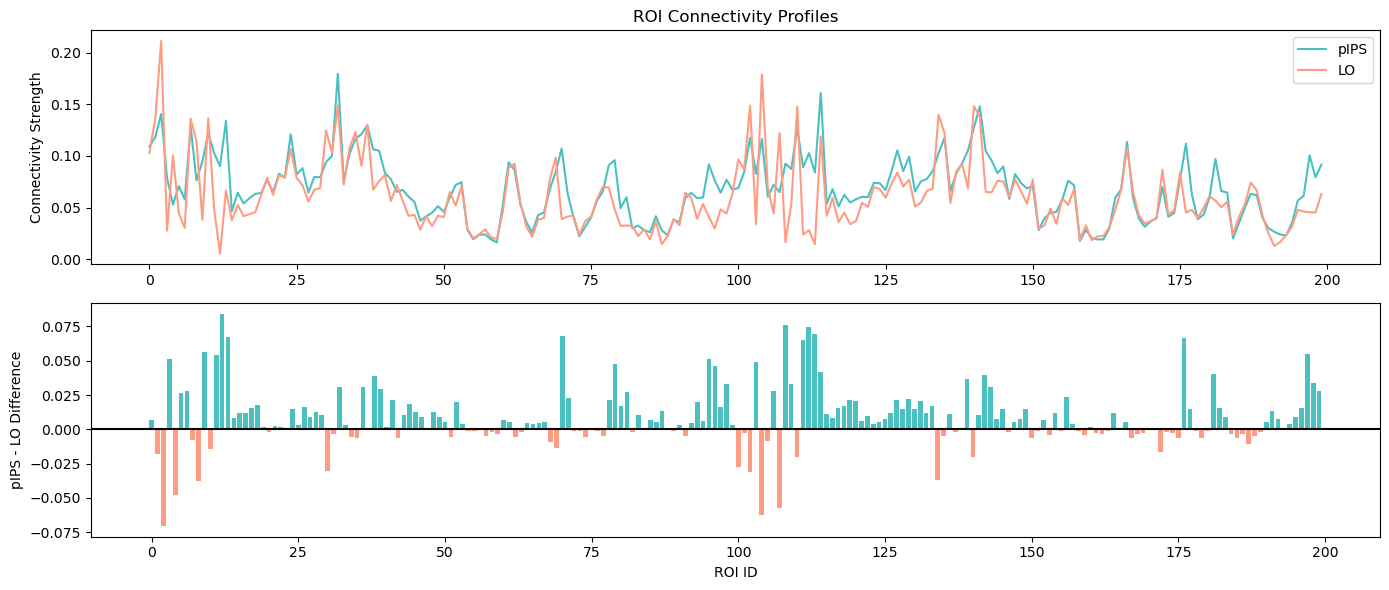

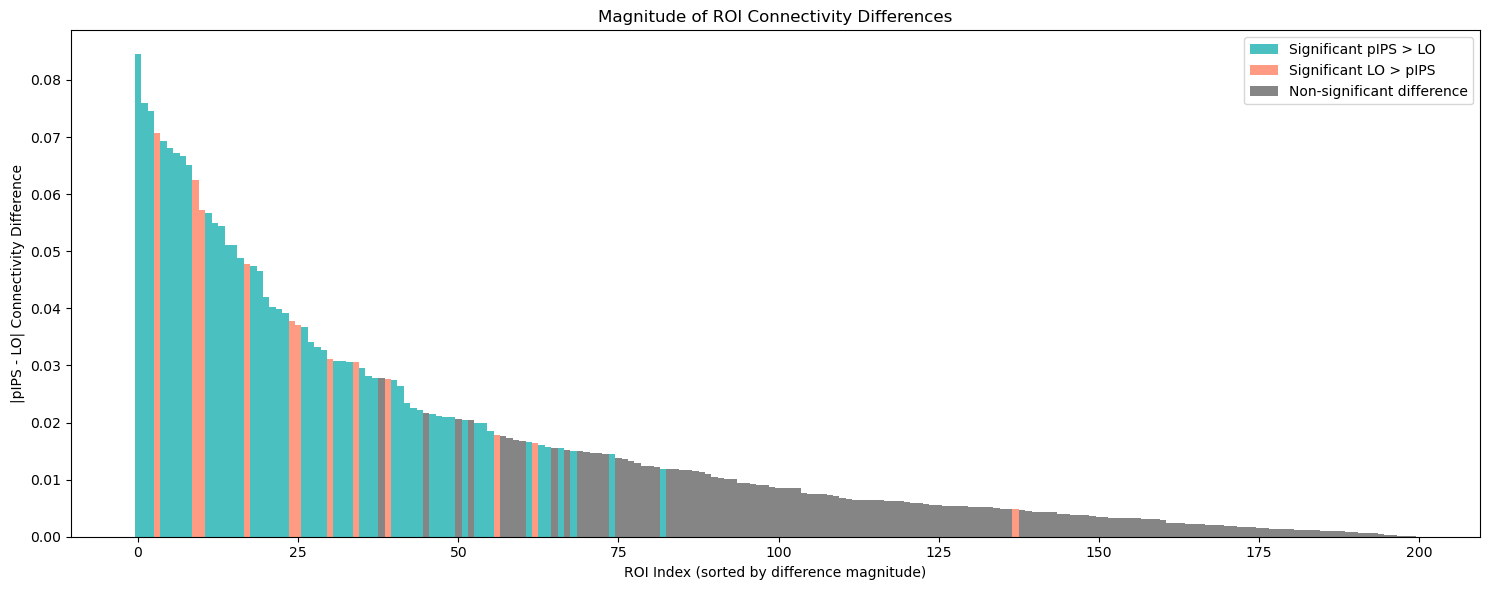

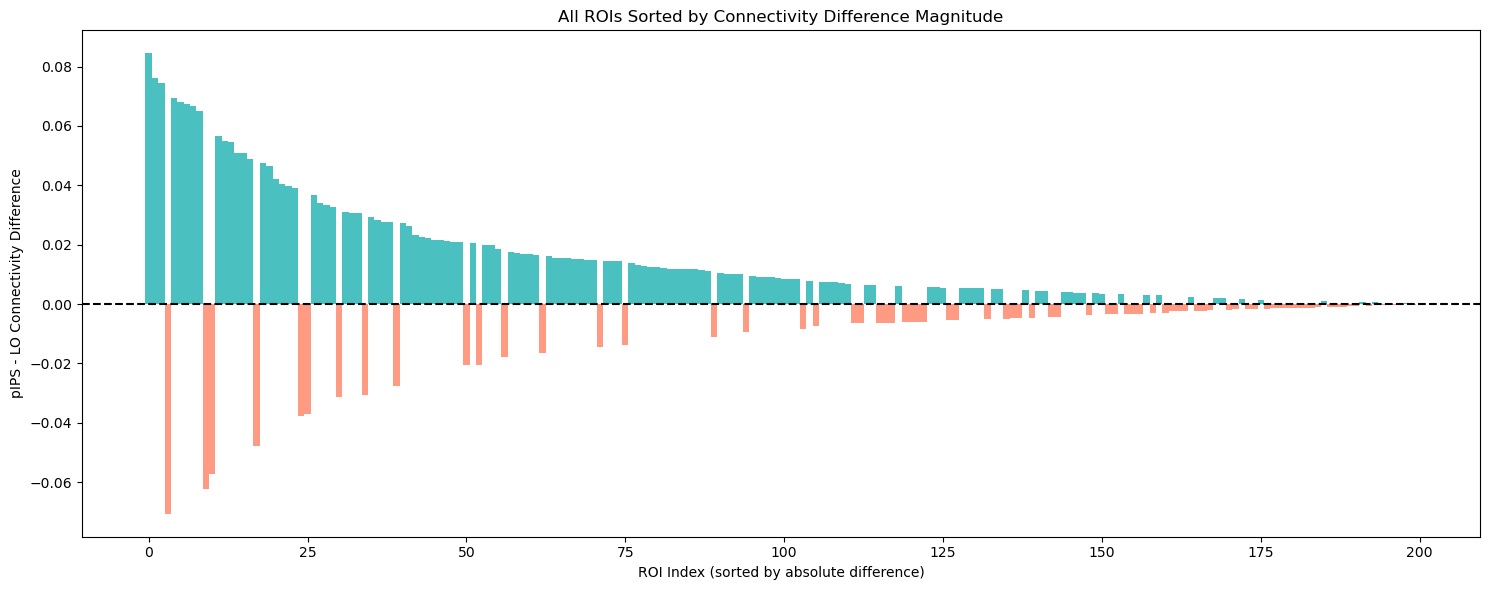

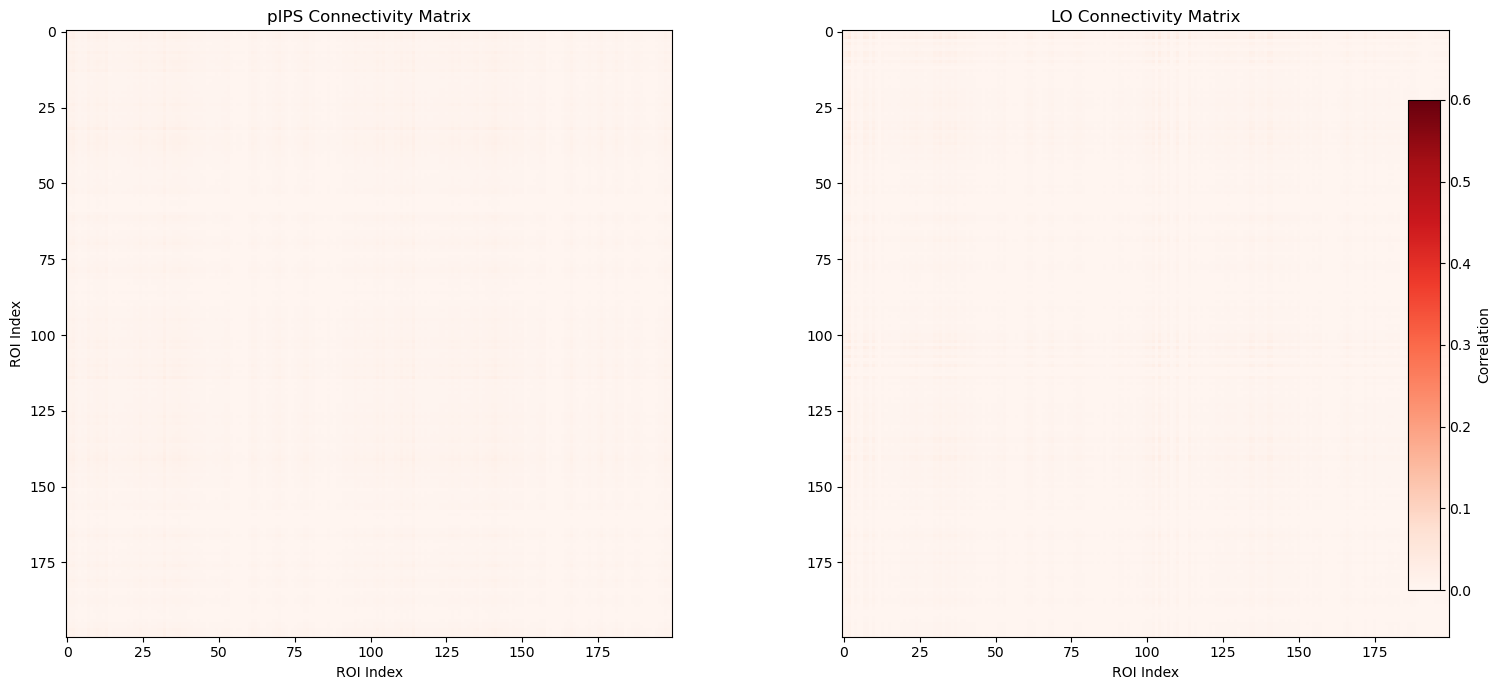

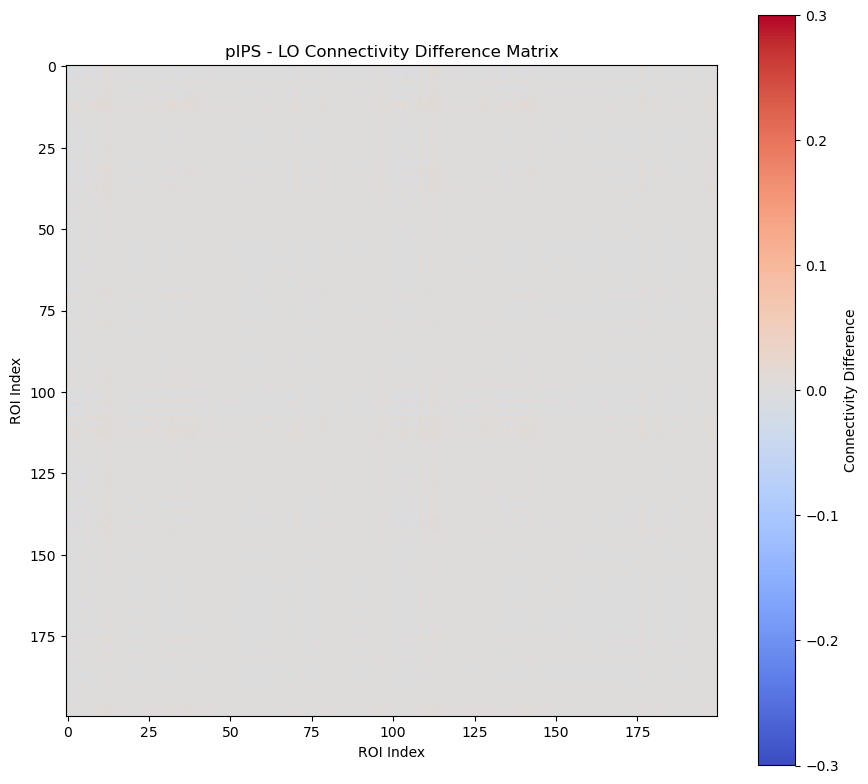

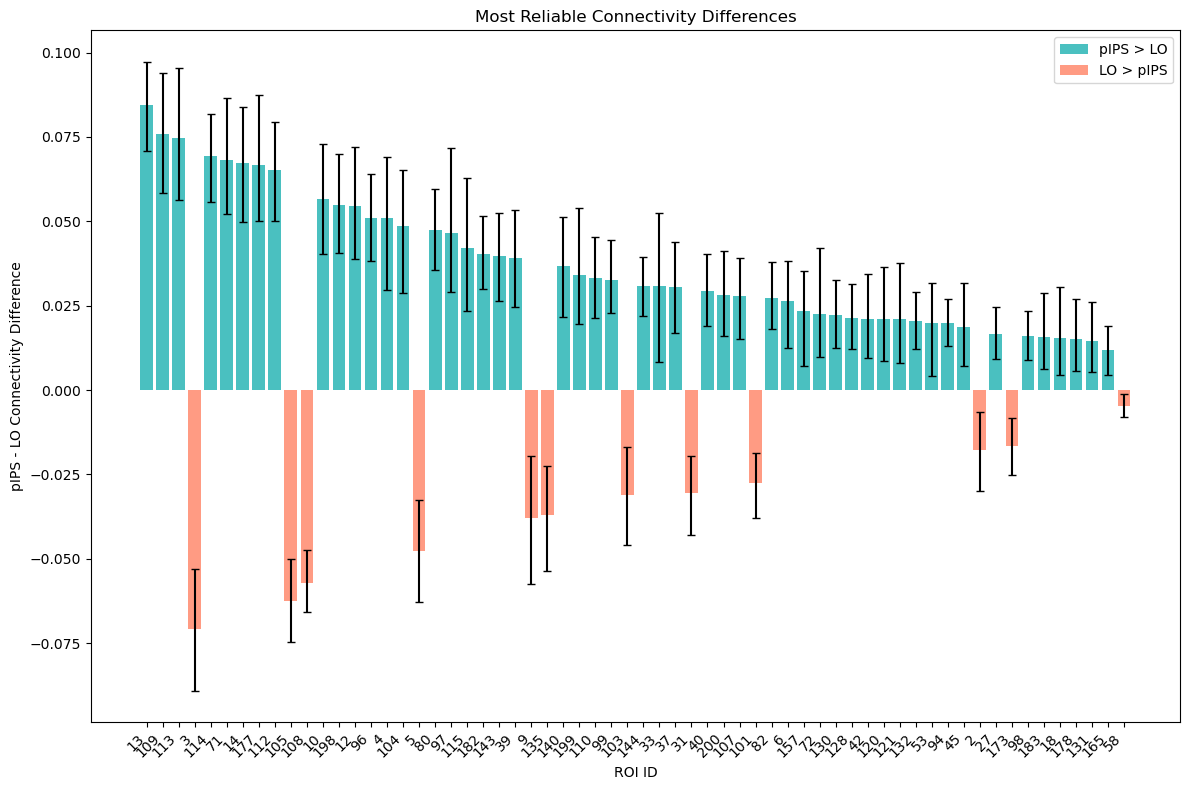

In [17]:
#Bilateral pIPS-LO Connectivity Fingerprint Analysis with Reliability Testing
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image, datasets, plotting
from nilearn.maskers import NiftiLabelsMasker
from scipy import stats
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection

# Define paths for your data
study_dir = "/lab_data/behrmannlab/vlad/ptoc"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
sub_info_path = '/user_data/csimmon2/git_repos/ptoc/sub_info.csv'
output_dir = f'{results_dir}/connectivity_comparison'
os.makedirs(output_dir, exist_ok=True)

# Load Schaefer atlas for reference
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
atlas_img = nib.load(atlas.maps)
atlas_labels = atlas.labels

def get_roi_name(roi_id):
    """Get the full name of an ROI from its ID"""
    try:
        idx = int(roi_id) - 1
        if 0 <= idx < len(atlas_labels):
            label = atlas_labels[idx]
            if isinstance(label, bytes):
                label = label.decode('utf-8')
            return label
    except:
        pass
    return f"ROI_{roi_id}"

def analyze_aggregated_bilateral_connectivity(run_bootstrap=True, run_loocv=True, run_permutation=False, n_perms=10000):
    """Analyze connectivity fingerprints with combined bilateral seeds"""
    print("Analyzing aggregated bilateral connectivity for pIPS and LO regions...")
    
    # Load subject info
    sub_info = pd.read_csv(sub_info_path)
    subjects = sub_info[sub_info['group'] == 'control']['sub'].tolist()
    print(f"Found {len(subjects)} control subjects")
    
    # Define ROIs and hemispheres
    rois = ['pIPS', 'LO']
    hemispheres = ['left', 'right']
    analysis_type = 'fc'
    
    # Setup atlas masker
    masker = NiftiLabelsMasker(labels_img=atlas_img, standardize=False)
    
    # Load and process subject data
    subject_data = []
    for sub in subjects:
        sub_conn = {}
        
        for roi in rois:
            # Initialize arrays to hold combined data
            combined_data = None
            hemi_count = 0
            
            for hemisphere in hemispheres:
                fc_file = f'{study_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_{roi}_{hemisphere}_loc_{analysis_type}_mni.nii.gz'
                
                if os.path.exists(fc_file):
                    try:
                        # Load the FC map
                        fc_img = nib.load(fc_file)
                        
                        # Extract ROI values using atlas
                        fc_values = masker.fit_transform(fc_img)[0]
                        
                        # Add to combined data
                        if combined_data is None:
                            combined_data = fc_values
                        else:
                            combined_data += fc_values
                        
                        hemi_count += 1
                    except Exception as e:
                        print(f"Error processing {fc_file}: {e}")
            
            # Average the data if we have at least one hemisphere
            if hemi_count > 0:
                sub_conn[roi] = combined_data / hemi_count
        
        # Only include subjects with both ROIs
        if len(sub_conn) == len(rois):
            subject_data.append(sub_conn)
    
    n_valid_subjects = len(subject_data)
    print(f"Successfully loaded data for {n_valid_subjects} subjects")
    
    if n_valid_subjects < 3:
        print("Not enough valid subjects. Analysis cannot proceed.")
        return None
    
    # Initialize arrays for analysis
    n_rois = len(atlas_labels)
    pips_fc = np.zeros((n_valid_subjects, n_rois))
    lo_fc = np.zeros((n_valid_subjects, n_rois))
    
    # Fill arrays with connectivity data
    for i, subj_data in enumerate(subject_data):
        pips_fc[i, :] = subj_data['pIPS']
        lo_fc[i, :] = subj_data['LO']
    
    # Calculate connectivity vector correlation for each subject
    vector_correlations = np.zeros(n_valid_subjects)
    for i in range(n_valid_subjects):
        vector_correlations[i] = np.corrcoef(pips_fc[i, :], lo_fc[i, :])[0, 1]
    
    print(f"Mean connectivity vector correlation: {np.mean(vector_correlations):.3f} ± {np.std(vector_correlations):.3f}")
    
    # Calculate mean connectivity profiles
    mean_pips = np.mean(pips_fc, axis=0)
    mean_lo = np.mean(lo_fc, axis=0)
    
    # Calculate difference profile
    diff_profile = mean_pips - mean_lo
    abs_diff_profile = np.abs(diff_profile)
    
    # Initialize variables for statistical testing
    sig_boot = np.zeros(n_rois, dtype=bool)
    ci_lower = np.zeros(n_rois)
    ci_upper = np.zeros(n_rois)
    sig_perm = np.zeros(n_rois, dtype=bool)
    perm_pvals = np.ones(n_rois)
    sig_loo = np.zeros(n_rois, dtype=bool)
    loo_reliability = np.zeros(n_rois)
    
    # 1. Bootstrap analysis for robust differences
    if run_bootstrap:
        print("Performing bootstrap analysis...")
        n_boots = 100000
        boot_diffs = np.zeros((n_boots, n_rois))
        
        for i in range(n_boots):
            # Resample subjects with replacement
            boot_idx = resample(range(n_valid_subjects), replace=True, n_samples=n_valid_subjects)
            
            # Calculate mean difference for this bootstrap sample
            boot_pips = np.mean(pips_fc[boot_idx, :], axis=0)
            boot_lo = np.mean(lo_fc[boot_idx, :], axis=0)
            boot_diffs[i, :] = boot_pips - boot_lo
        
        # Calculate confidence intervals
        ci_lower = np.percentile(boot_diffs, 2.5, axis=0)
        ci_upper = np.percentile(boot_diffs, 97.5, axis=0)
        
        # Identify significant differences (95% CI doesn't cross zero)
        sig_boot = (ci_lower > 0) | (ci_upper < 0)
        sig_boot_count = np.sum(sig_boot)
        print(f"Found {sig_boot_count} ROIs with significant differences via bootstrap")
    
    # 2. Permutation testing for exact p-values
    if run_permutation:
        print(f"Performing permutation testing with {n_perms} permutations...")
        # Calculate observed differences
        observed_diffs = diff_profile
        
        # Initialize array to store permutation results
        perm_diffs = np.zeros((n_perms, n_rois))
        
        # Perform permutations
        for i in range(n_perms):
            # For each subject, randomly swap pIPS and LO connectivity values
            perm_pips = np.zeros_like(pips_fc)
            perm_lo = np.zeros_like(lo_fc)
            
            for s in range(n_valid_subjects):
                if np.random.rand() > 0.5:
                    perm_pips[s, :] = pips_fc[s, :]
                    perm_lo[s, :] = lo_fc[s, :]
                else:
                    perm_pips[s, :] = lo_fc[s, :]
                    perm_lo[s, :] = pips_fc[s, :]
            
            # Calculate permuted difference
            perm_diffs[i, :] = np.mean(perm_pips - perm_lo, axis=0)
        
        # Calculate two-tailed p-values
        perm_pvals = np.zeros(n_rois)
        for r in range(n_rois):
            if observed_diffs[r] >= 0:
                perm_pvals[r] = np.mean(perm_diffs[:, r] >= observed_diffs[r])
            else:
                perm_pvals[r] = np.mean(perm_diffs[:, r] <= observed_diffs[r])
        
        # Double for two-tailed test
        perm_pvals = np.minimum(perm_pvals * 2, 1.0)
        
        # Apply FDR correction
        _, perm_pvals_fdr = fdrcorrection(perm_pvals, alpha=0.05)
        
        # Identify significant differences
        sig_perm = perm_pvals_fdr < 0.05
        sig_perm_count = np.sum(sig_perm)
        print(f"Found {sig_perm_count} ROIs with significant differences via permutation testing (FDR-corrected)")
    
    # 3. Leave-One-Out Cross-Validation for reliability
    if run_loocv:
        print("Performing Leave-One-Out Cross-Validation...")
        loo_reliability = np.zeros(n_rois)
        
        for left_out in range(n_valid_subjects):
            # Create the training set (all subjects except the left out one)
            train_idx = list(range(n_valid_subjects))
            train_idx.remove(left_out)
            
            # Calculate mean training differences
            train_diff = np.mean(pips_fc[train_idx, :] - lo_fc[train_idx, :], axis=0)
            
            # Test on left out subject
            test_diff = pips_fc[left_out, :] - lo_fc[left_out, :]
            
            # Calculate consistency of signs between training and test
            loo_reliability += (np.sign(train_diff) == np.sign(test_diff)).astype(float)
        
        # Convert to proportion of consistent predictions
        loo_reliability = loo_reliability / n_valid_subjects
        
        # Set threshold at 75% consistency
        loo_threshold = 0.75
        sig_loo = loo_reliability >= loo_threshold
        sig_loo_count = np.sum(sig_loo)
        
        print(f"LOO reliability threshold: {loo_threshold:.3f}")
        print(f"Found {sig_loo_count} ROIs with high reliability via LOO")
    
    # Combine significance based on which tests are run
    sig_combined = np.zeros(n_rois, dtype=bool)
    
    if run_bootstrap and not run_permutation and not run_loocv:
        sig_combined = sig_boot
    elif run_bootstrap and run_permutation and not run_loocv:
        sig_combined = sig_boot & sig_perm
    elif run_bootstrap and run_loocv and not run_permutation:
        sig_combined = sig_boot & sig_loo
    elif run_permutation and run_loocv and not run_bootstrap:
        sig_combined = sig_perm & sig_loo
    elif run_bootstrap and run_permutation and run_loocv:
        sig_combined = (sig_boot & sig_perm) | (sig_boot & sig_loo) | (sig_perm & sig_loo)
    elif run_permutation and not run_bootstrap and not run_loocv:
        sig_combined = sig_perm
    elif run_loocv and not run_bootstrap and not run_permutation:
        sig_combined = sig_loo
    
    sig_combined_count = np.sum(sig_combined)
    print(f"Found {sig_combined_count} ROIs significant with combined criteria")
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'ROI_ID': np.arange(1, n_rois + 1),
        'pIPS_Connectivity': mean_pips,
        'LO_Connectivity': mean_lo,
        'Difference': diff_profile,
        'Abs_Difference': abs_diff_profile,
        'CI_Lower': ci_lower,
        'CI_Upper': ci_upper
    })
    
    # Add statistical test results if run
    if run_bootstrap:
        results_df['Bootstrap_Significant'] = sig_boot
    if run_permutation:
        results_df['Permutation_PValue'] = perm_pvals
        results_df['Permutation_Significant'] = sig_perm
    if run_loocv:
        results_df['LOO_Reliability'] = loo_reliability
        results_df['LOO_Significant'] = sig_loo
    
    results_df['Combined_Significant'] = sig_combined
    
    # Add ROI names
    results_df['ROI_Name'] = results_df['ROI_ID'].apply(get_roi_name)
    
    # Identify ROI direction (pIPS>LO or LO>pIPS)
    results_df['Direction'] = np.where(results_df['Difference'] > 0, 'pIPS > LO', 'LO > pIPS')
    
    # Visualize connectivity profiles
    plt.figure(figsize=(14, 6))
    plt.subplot(2, 1, 1)
    x = np.arange(n_rois)
    plt.plot(x, mean_pips, color='#4ac0c0', linestyle='-', label='pIPS')  # Teal for pIPS
    plt.plot(x, mean_lo, color='#ff9b83', linestyle='-', label='LO')      # Peach for LO
    plt.ylabel('Connectivity Strength')
    plt.title('ROI Connectivity Profiles')
    plt.legend()

    plt.subplot(2, 1, 2)
    colors = ['#4ac0c0' if val > 0 else '#ff9b83' for val in diff_profile]  # Teal for pIPS>LO, Peach for LO>pIPS
    plt.bar(x, diff_profile, color=colors)
    plt.axhline(y=0, color='black', linestyle='-')
    plt.ylabel('pIPS - LO Difference')
    plt.xlabel('ROI ID')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/bilateral_connectivity_profiles.png', dpi=300)
    
    # Create figure showing all ROIs sorted by absolute difference
    plt.figure(figsize=(15, 6))
    sorted_idx = np.argsort(abs_diff_profile)[::-1]  # Sort by absolute difference

    # Colorblind-friendly palette
    # - teal: significant pIPS > LO
    # - peach: significant LO > pIPS 
    # - Gray: not significant
    colors = []
    for i in sorted_idx:
        if sig_combined[i]:
            if diff_profile[i] > 0:
                colors.append('#4ac0c0')  # Teal for pIPS
            else:
                colors.append('#ff9b83')  # Peach for LO
        else:
            colors.append('#858585')      # Gray

    # Plot bars all pointing upward
    plt.bar(range(len(sorted_idx)), abs_diff_profile[sorted_idx], color=colors, width=1.0)

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#4ac0c0', label='Significant pIPS > LO'),
        Patch(facecolor='#ff9b83', label='Significant LO > pIPS'),
        Patch(facecolor='#858585', label='Non-significant difference')
    ]
    plt.legend(handles=legend_elements)

    plt.xlabel('ROI Index (sorted by difference magnitude)')
    plt.ylabel('|pIPS - LO| Connectivity Difference')
    plt.title('Magnitude of ROI Connectivity Differences')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/all_connectivity_differences_magnitude.png', dpi=300)

    # Create figure showing all ROIs sorted by absolute difference
    plt.figure(figsize=(15, 6))
    sorted_idx = np.argsort(abs_diff_profile)[::-1]  # Sort by absolute difference

    # Plot bars with color coding
    plt.bar(range(len(sorted_idx)), diff_profile[sorted_idx], 
        color=['#4ac0c0' if diff > 0 else '#ff9b83' for diff in diff_profile[sorted_idx]], 
        width=1.0)

    plt.axhline(y=0, color='black', linestyle='--')
    plt.xlabel('ROI Index (sorted by absolute difference)')
    plt.ylabel('pIPS - LO Connectivity Difference')
    plt.title('All ROIs Sorted by Connectivity Difference Magnitude')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/all_connectivity_differences_sorted.png', dpi=300)
    
    def plot_connectivity_matrices(pips_fc, lo_fc, merged_atlas_info):
        """
        Plot connectivity matrices showing ROI-to-ROI connectivity for pIPS and LO
        
        Parameters:
        -----------
        pips_fc : numpy.ndarray
            Subject x ROI matrix of pIPS connectivity values
        lo_fc : numpy.ndarray
            Subject x ROI matrix of LO connectivity values
        merged_atlas_info : dict
            Information about the merged atlas
        """
        # Calculate mean connectivity profiles
        mean_pips = np.mean(pips_fc, axis=0)
        mean_lo = np.mean(lo_fc, axis=0)
        
        # Get atlas information
        n_rois = len(mean_pips)
        
        # Create 2D matrices of all ROI-to-ROI correlations
        # For each ROI, we use its connectivity profile vector as a row in the matrix
        pips_matrix = np.outer(mean_pips, mean_pips)  # Outer product creates matrix of all pair combinations
        lo_matrix = np.outer(mean_lo, mean_lo)
        
        # Create figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
        
        # Plot matrices
        vmin, vmax = 0, 0.6  # Adjust based on your data range
        im1 = ax1.imshow(pips_matrix, cmap='Reds', vmin=vmin, vmax=vmax)
        ax1.set_title('pIPS Connectivity Matrix')
        ax1.set_xlabel('ROI Index')
        ax1.set_ylabel('ROI Index')
        
        im2 = ax2.imshow(lo_matrix, cmap='Reds', vmin=vmin, vmax=vmax)
        ax2.set_title('LO Connectivity Matrix')
        ax2.set_xlabel('ROI Index')
        
        # Add colorbar
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        fig.colorbar(im2, cax=cbar_ax, label='Correlation')
        
        plt.tight_layout()
        plt.savefig(f'{output_dir}/connectivity_matrices.png', dpi=300)
        
        # Create a difference matrix
        diff_matrix = pips_matrix - lo_matrix
        
        plt.figure(figsize=(9, 8))
        im = plt.imshow(diff_matrix, cmap='coolwarm', vmin=-0.3, vmax=0.3)
        plt.title('pIPS - LO Connectivity Difference Matrix')
        plt.xlabel('ROI Index')
        plt.ylabel('ROI Index')
        plt.colorbar(label='Connectivity Difference')
        plt.tight_layout()
        plt.savefig(f'{output_dir}/connectivity_difference_matrix.png', dpi=300)
    
    plot_connectivity_matrices(pips_fc, lo_fc, atlas_labels)
    
    # Visualize top reliable differences
    top_rois = results_df[results_df['Combined_Significant']].sort_values('Abs_Difference', ascending=False)
    
    if len(top_rois) > 0:
        plt.figure(figsize=(12, 8))
        x = np.arange(len(top_rois))
        
        # Color by direction
        colors = np.where(top_rois['Difference'] > 0, '#4ac0c0', '#ff9b83')  # Teal for pIPS>LO, Peach for LO>pIPS
        
        plt.bar(x, top_rois['Difference'], color=colors)
        plt.errorbar(x, top_rois['Difference'], 
                     yerr=[top_rois['Difference'] - top_rois['CI_Lower'], 
                           top_rois['CI_Upper'] - top_rois['Difference']], 
                     fmt='none', color='black', capsize=3)
        
        # Add ROI labels
        plt.xticks(x, [f"{row['ROI_ID']}" for _, row in top_rois.iterrows()], rotation=45, ha='right')
        
        plt.xlabel('ROI ID')
        plt.ylabel('pIPS - LO Connectivity Difference')
        plt.title('Most Reliable Connectivity Differences')
        
        # Add a legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='#4ac0c0', label='pIPS > LO'),  # Teal for pIPS>LO
            Patch(facecolor='#ff9b83', label='LO > pIPS')    # Peach for LO>pIPS
        ]
        plt.legend(handles=legend_elements)
        
        plt.tight_layout()
        plt.savefig(f'{output_dir}/bilateral_reliable_differences.png', dpi=300)
    
    # Save results to CSV
    results_df.to_csv(f'{output_dir}/bilateral_connectivity_fingerprint_results.csv', index=False)
    
    # Print top ROIs
    if len(top_rois) > 0:
        print("\nTop most reliable bilateral connectivity differences:")
        for i, (_, row) in enumerate(top_rois.head(15).iterrows()):
            print(f"{i+1}. ROI_{row['ROI_ID']} ({row['ROI_Name']}): " +
                  f"Diff = {row['Difference']:.3f} [{row['CI_Lower']:.3f}, {row['CI_Upper']:.3f}], " +
                  f"Direction: {row['Direction']}")
    
    # Prepare return dictionary
    result_dict = {
        'results': results_df,
        'vector_correlations': vector_correlations
    }
    
    # Add test results if run
    if run_bootstrap:
        result_dict['bootstrap_sig_count'] = np.sum(sig_boot)
    if run_permutation:
        result_dict['perm_sig_count'] = np.sum(sig_perm)
    if run_loocv:
        result_dict['loo_sig_count'] = np.sum(sig_loo)
    
    result_dict['combined_sig_count'] = sig_combined_count
    
    return result_dict

# Run the analysis with chosen methods
results = analyze_aggregated_bilateral_connectivity(run_bootstrap=True, run_loocv=True, run_permutation=False)

Visualization complete with corrected connections!


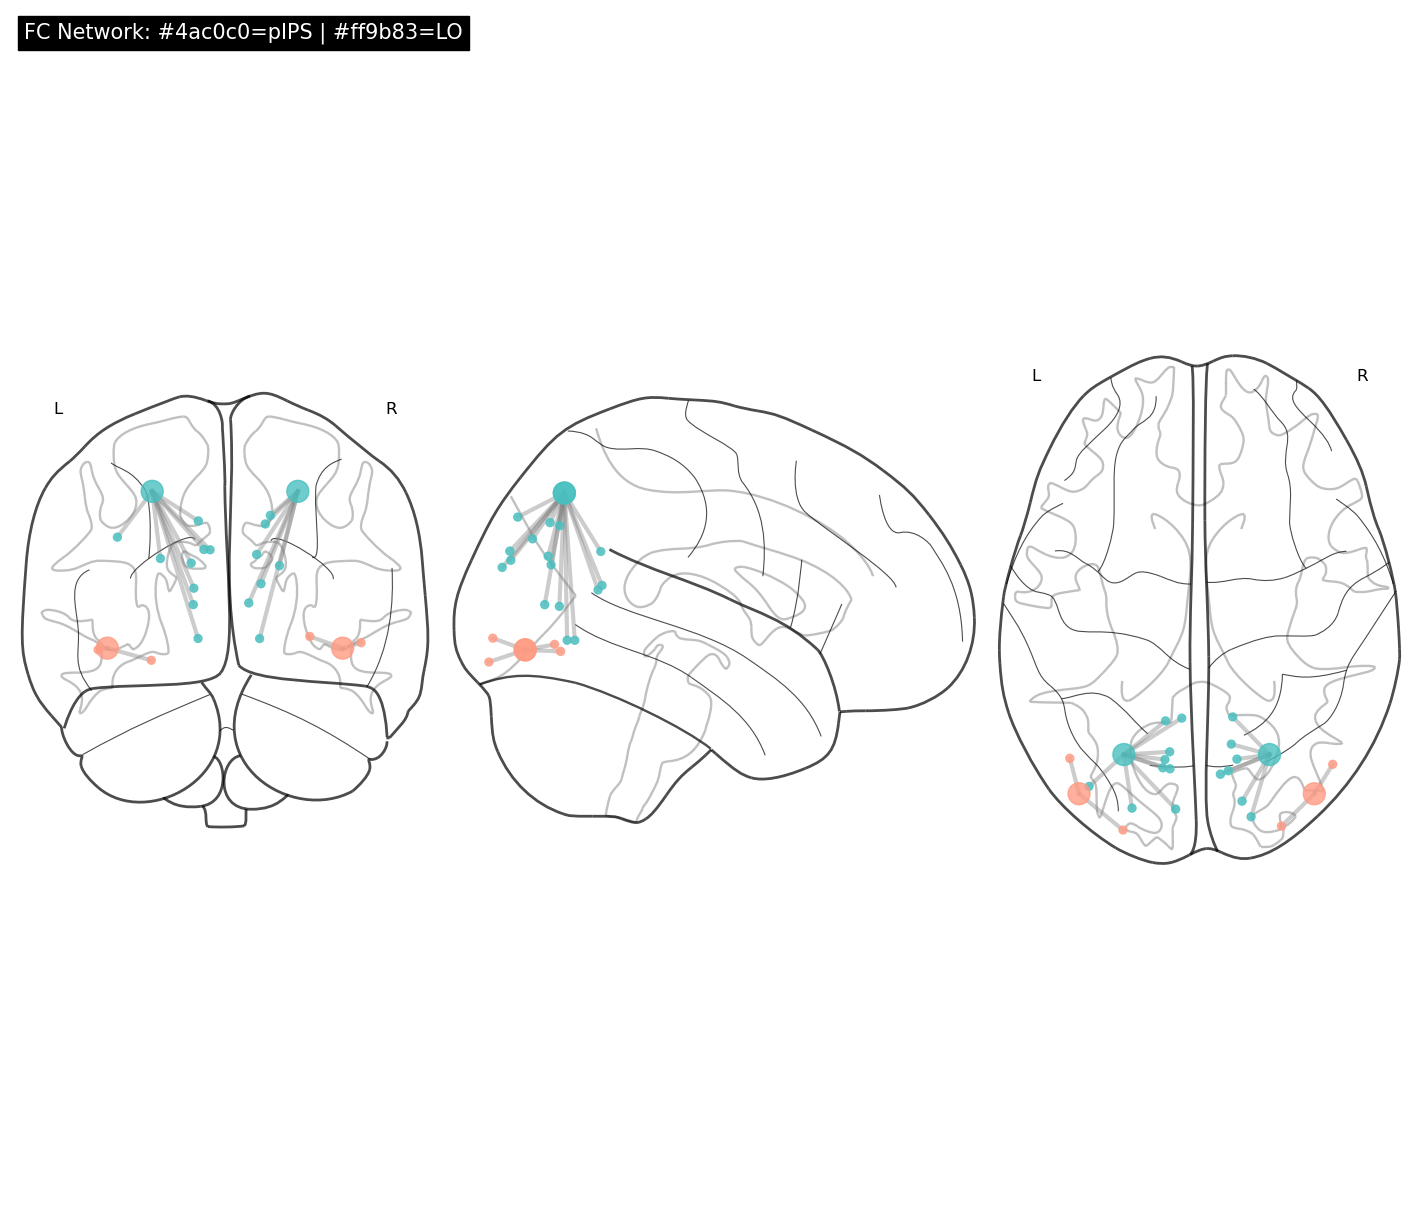

In [25]:
# Network visualization
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import plotting, datasets
import matplotlib.pyplot as plt

# Setup directories
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
output_dir = f'{results_dir}/connectivity_analysis'
vis_dir = f'{output_dir}/visualizations'
os.makedirs(vis_dir, exist_ok=True)

# Load atlas and results
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
atlas_img = nib.load(atlas.maps)
atlas_labels = [l.decode('utf-8') if isinstance(l, bytes) else l for l in atlas.labels]

# Load FC results
fc_results = pd.read_csv(f'{output_dir}/bilateral_fc_connectivity_results.csv')
fc_sig = fc_results[fc_results['Combined_Significant']].copy()

# Extract hemisphere information 
fc_sig.loc[:, 'Hemisphere'] = fc_sig['ROI_Name'].apply(lambda x: 'L' if 'LH' in x else 'R')

# Extract coordinates
atlas_data = atlas_img.get_fdata()
affine = atlas_img.affine

# Initialize storage with target tracking (NEW)
left_coords = []
left_sizes = []
left_colors = []
left_targets = []  # 0=pIPS, 1=LO
left_roi_ids = []

right_coords = []
right_sizes = []
right_colors = []
right_targets = []  # 0=pIPS, 1=LO 
right_roi_ids = []

# Process ROIs with target tracking
for _, row in fc_sig.iterrows():
    roi_id = int(row['ROI_ID'])
    roi_voxels = np.where(atlas_data == roi_id)
    if len(roi_voxels[0]) == 0:
        continue
        
    centroid = np.array([np.mean(roi_voxels[0]), np.mean(roi_voxels[1]), np.mean(roi_voxels[2])])
    mni_coord = np.dot(affine, np.append(centroid, 1))[:3]
    
    abs_diff = abs(row['Difference'])
    node_size = abs_diff * 50 + 30
    
    # NEW: Store target separately from color
    node_target = 0 if row['Difference'] > 0 else 1
    node_color = '#4ac0c0' if node_target == 0 else '#ff9b83'  # Your exact colors
    
    if row['Hemisphere'] == 'L':
        left_coords.append(mni_coord)
        left_sizes.append(node_size)
        left_colors.append(node_color)
        left_targets.append(node_target)
        left_roi_ids.append(roi_id)
    else:
        right_coords.append(mni_coord)
        right_sizes.append(node_size)
        right_colors.append(node_color)
        right_targets.append(node_target)
        right_roi_ids.append(roi_id)

# Seed coordinates (unchanged)
left_pips = [-26, -68, 48]
right_pips = [26, -68, 48] 
left_lo = [-42, -82, -8]
right_lo = [42, -82, -8]

# Combine coordinates (unchanged)
all_left_coords = left_coords + [left_pips, left_lo]
all_right_coords = right_coords + [right_pips, right_lo]
all_left_sizes = left_sizes + [250, 250]
all_right_sizes = right_sizes + [250, 250]

# Apply your color scheme to seeds
all_left_colors = left_colors + ['#4ac0c0', '#ff9b83']  # pIPS, LO
all_right_colors = right_colors + ['#4ac0c0', '#ff9b83']  # pIPS, LO

# Create adjacency matrices using TARGETS not colors
n_left = len(all_left_coords)
n_left_rois = len(left_coords)
left_adjacency = np.zeros((n_left, n_left))

for i in range(n_left_rois):
    target_idx = n_left_rois + left_targets[i]  # Connect to correct seed
    left_adjacency[i, target_idx] = 1
    left_adjacency[target_idx, i] = 1

n_right = len(all_right_coords)
n_right_rois = len(right_coords) 
right_adjacency = np.zeros((n_right, n_right))

for i in range(n_right_rois):
    target_idx = n_right_rois + right_targets[i]
    right_adjacency[i, target_idx] = 1
    right_adjacency[target_idx, i] = 1

# Create plot (unchanged parameters)
fig = plt.figure(figsize=(14, 12))
all_coords = all_left_coords + all_right_coords
all_sizes = all_left_sizes + all_right_sizes
all_colors = all_left_colors + all_right_colors
n_total = len(all_coords)
all_adjacency = np.zeros((n_total, n_total))
all_adjacency[:n_left, :n_left] = left_adjacency
all_adjacency[n_left:, n_left:] = right_adjacency

plotting.plot_connectome(
    all_adjacency,
    all_coords,
    node_size=all_sizes,
    node_color=all_colors,
    edge_kwargs={'color': 'gray', 'alpha': 0.4},
    node_kwargs={'alpha': 0.8},
    title='FC Network: #4ac0c0=pIPS | #ff9b83=LO',
    figure=fig
)

plt.savefig(f'{vis_dir}/fc_network_custom_colors_fixed.png', dpi=300, bbox_inches='tight')

# Save legend (unchanged)
legend_info = pd.DataFrame({
    'ROI_ID': left_roi_ids + right_roi_ids,
    'Hemisphere': ['L']*len(left_roi_ids) + ['R']*len(right_roi_ids),
    'Network': ['pIPS' if t == 0 else 'LO' for t in left_targets + right_targets],
    'Color': ['#4ac0c0' if t == 0 else '#ff9b83' for t in left_targets + right_targets],
    'ROI_Name': [atlas_labels[i-1] for i in left_roi_ids + right_roi_ids]
})
legend_info.to_csv(f'{vis_dir}/network_legend.csv', index=False)

print("Visualization complete with corrected connections!")

Running connectivity analysis...


Analysis complete. Found 62 significant ROIs
Creating visualizations...
Visualizations saved to /user_data/csimmon2/git_repos/ptoc/results/connectivity_analysis/visualizations
Pipeline completed successfully!


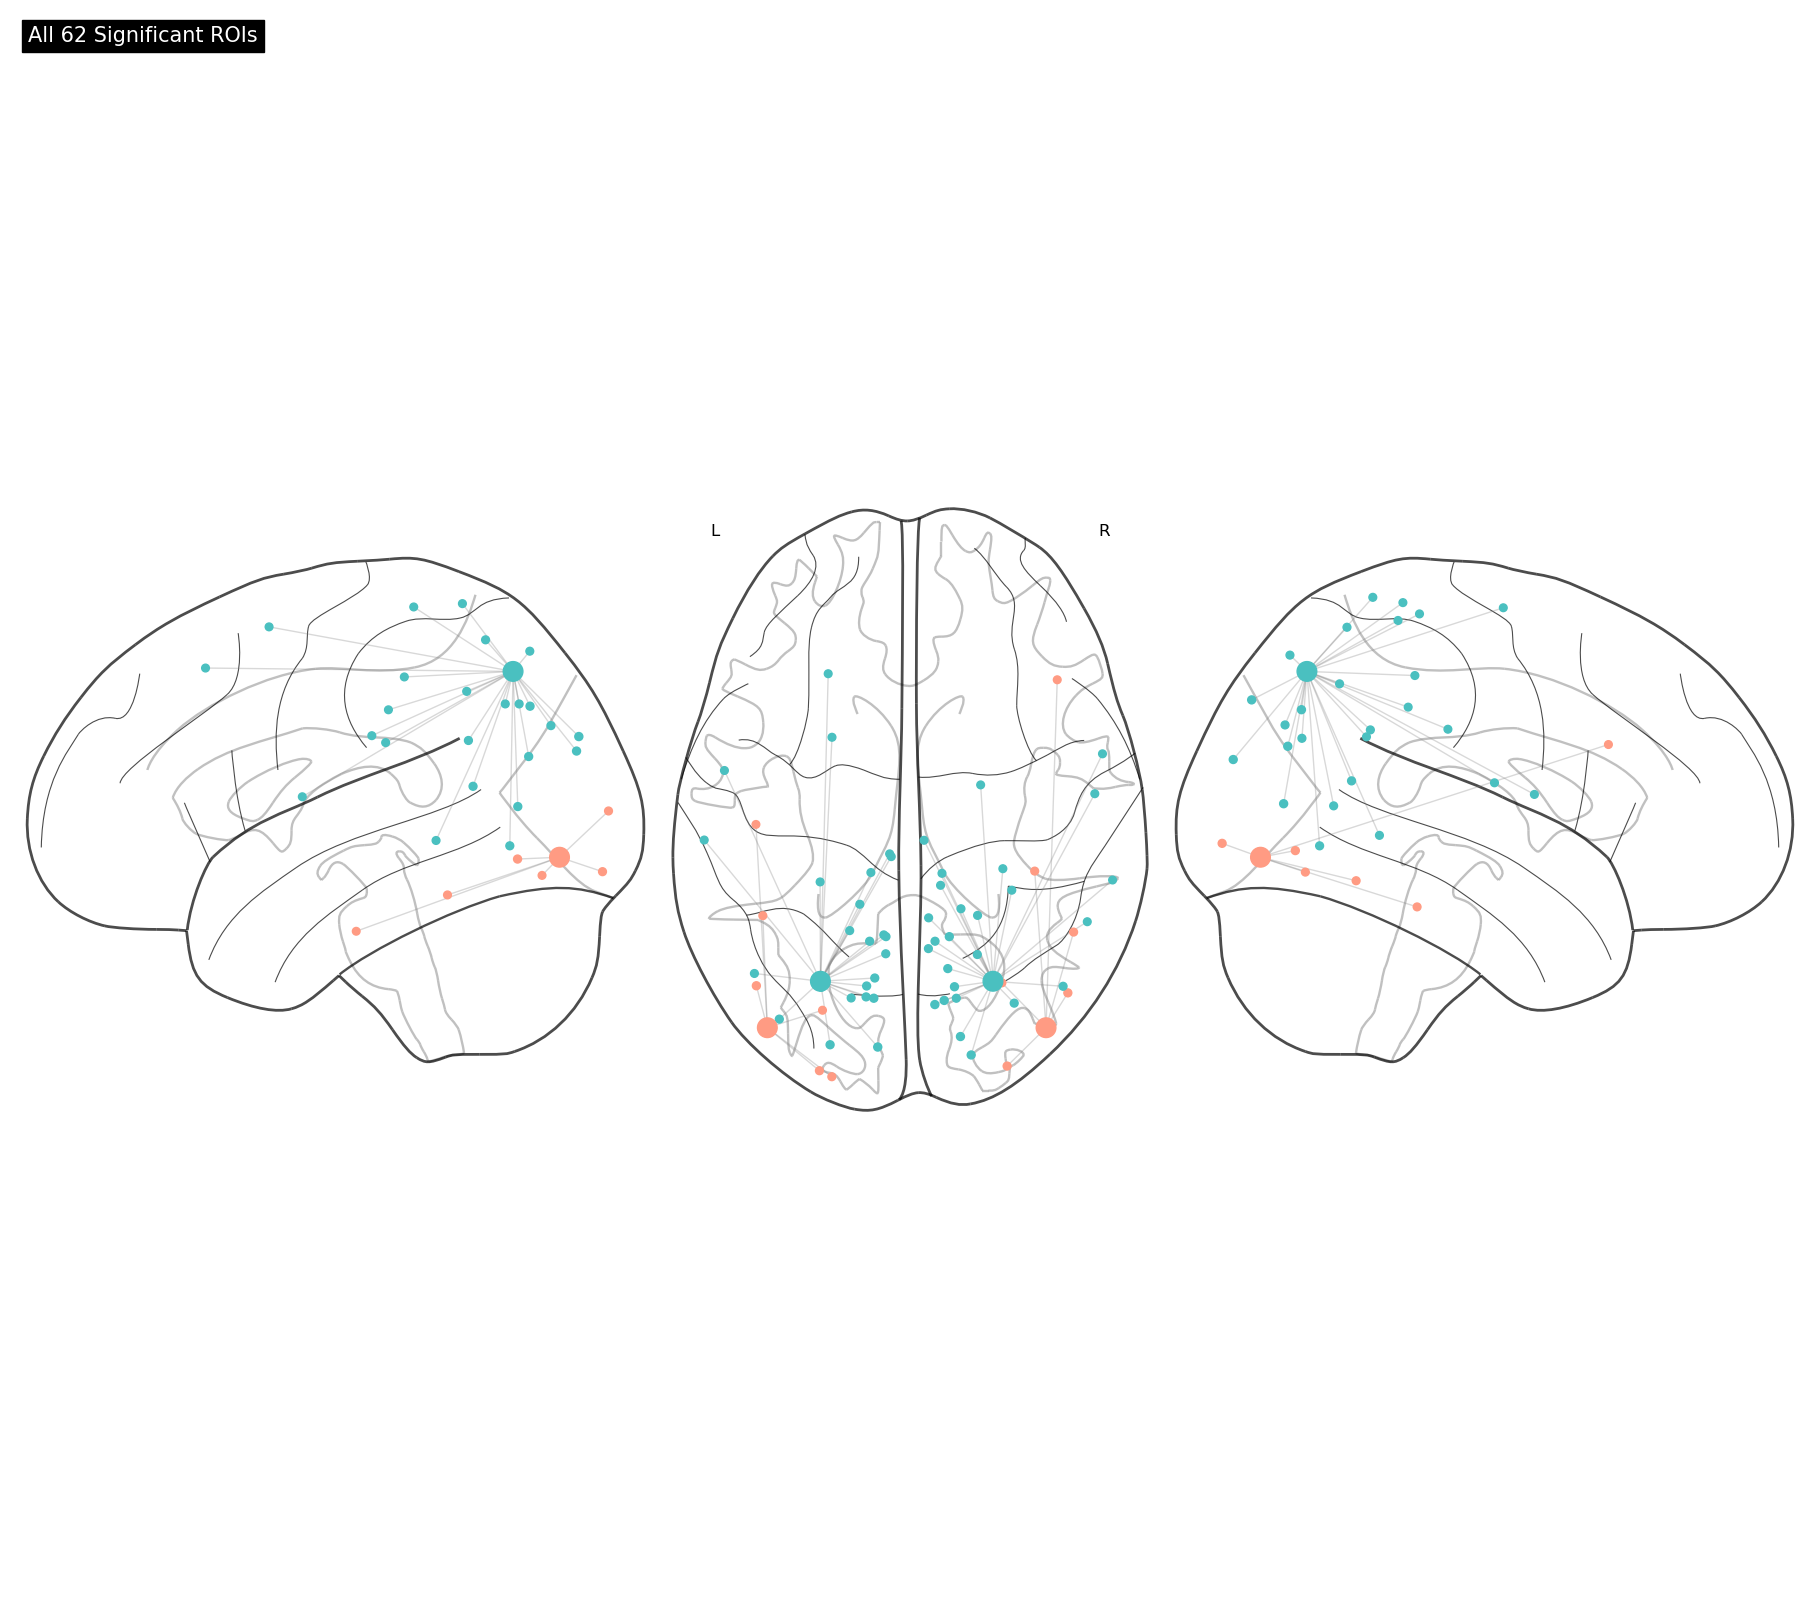

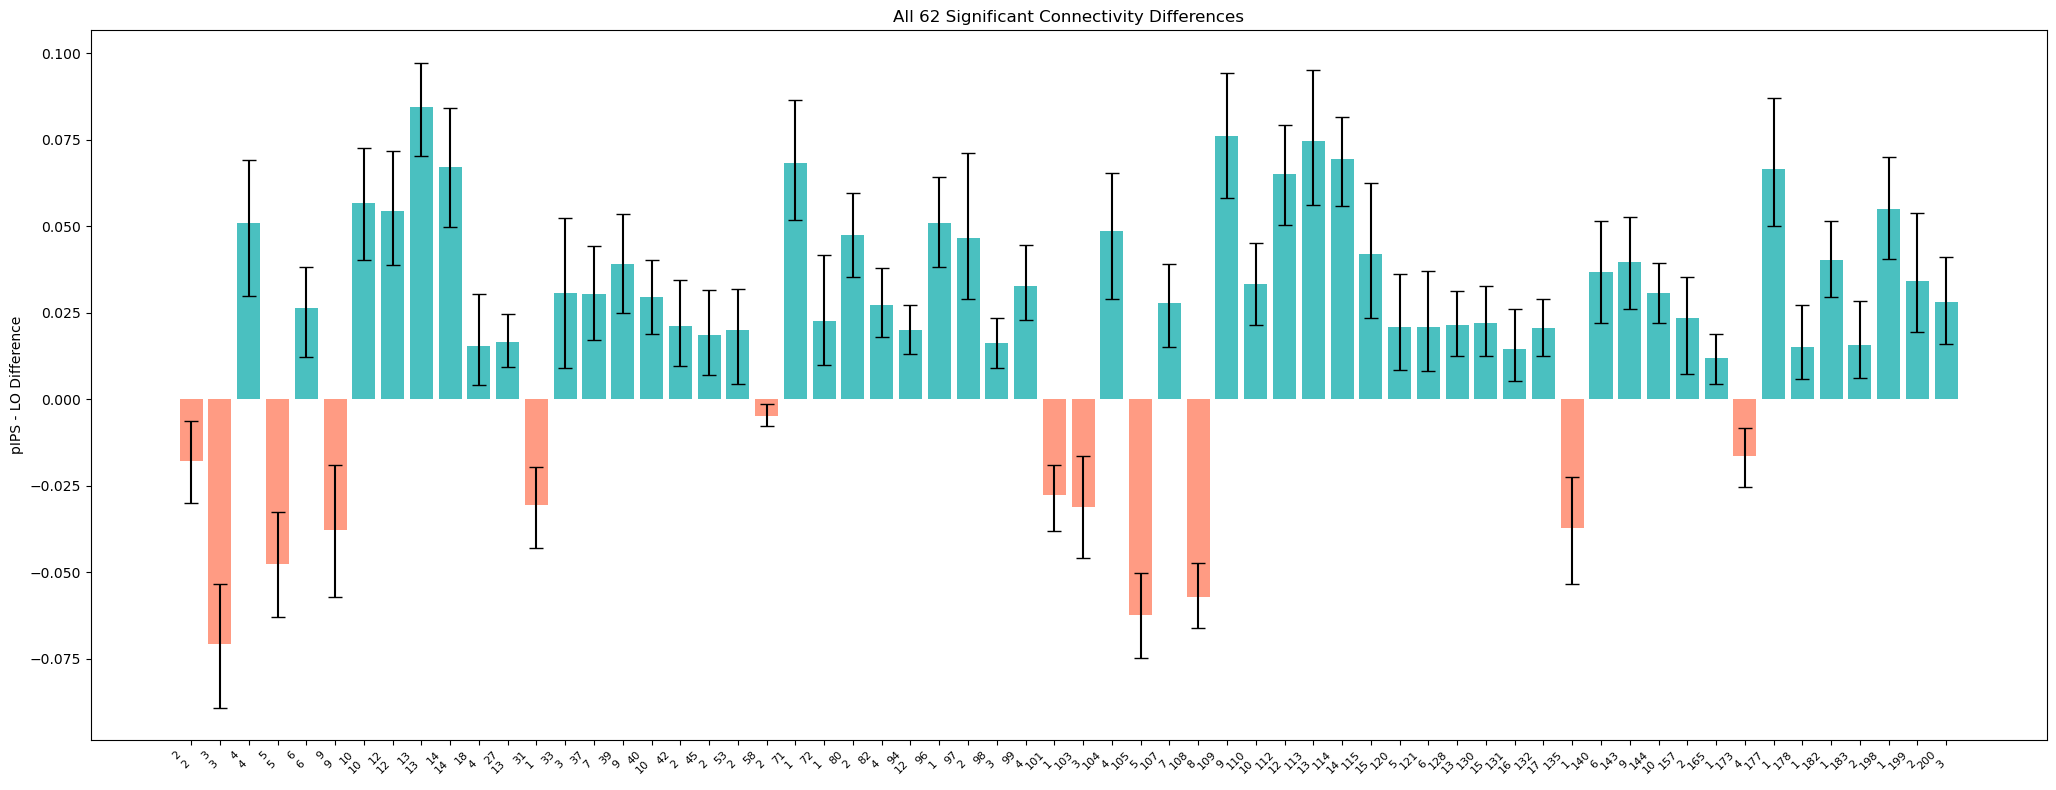

In [35]:
# COMPLETE CONNECTIVITY ANALYSIS & VISUALIZATION SCRIPT
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import plotting, datasets, image
from nilearn.maskers import NiftiLabelsMasker
from scipy import stats
from sklearn.utils import resample
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ========================
# 1. SETUP AND PATHS
# ========================
study_dir = "/lab_data/behrmannlab/vlad/ptoc"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
sub_info_path = '/user_data/csimmon2/git_repos/ptoc/sub_info.csv'
output_dir = f'{results_dir}/connectivity_analysis'
vis_dir = f'{output_dir}/visualizations'
os.makedirs(vis_dir, exist_ok=True)

# ========================
# 2. ANALYSIS FUNCTION
# ========================
def run_connectivity_analysis():
    """Run full connectivity analysis and return results with significant ROIs"""
    print("Running connectivity analysis...")
    
    # Load atlas and subjects
    atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
    atlas_img = nib.load(atlas.maps)
    sub_info = pd.read_csv(sub_info_path)
    subjects = sub_info[sub_info['group'] == 'control']['sub'].tolist()
    
    # Initialize data storage
    masker = NiftiLabelsMasker(labels_img=atlas_img, standardize=False)
    subject_data = []
    
    # Process each subject
    for sub in subjects:
        sub_conn = {}
        for roi in ['pIPS', 'LO']:
            combined_data, hemi_count = None, 0
            for hem in ['left', 'right']:
                fc_file = f'{study_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_{roi}_{hem}_loc_fc_mni.nii.gz'
                if os.path.exists(fc_file):
                    try:
                        fc_data = masker.fit_transform(nib.load(fc_file))[0]
                        combined_data = fc_data if combined_data is None else combined_data + fc_data
                        hemi_count += 1
                    except Exception as e:
                        print(f"Error processing {fc_file}: {e}")
            if hemi_count > 0:
                sub_conn[roi] = combined_data / hemi_count
        
        if len(sub_conn) == 2:
            subject_data.append(sub_conn)
    
    # Create group matrices
    pips_fc = np.array([s['pIPS'] for s in subject_data])
    lo_fc = np.array([s['LO'] for s in subject_data])
    
    # Calculate group differences
    mean_pips = np.mean(pips_fc, axis=0)
    mean_lo = np.mean(lo_fc, axis=0)
    diff = mean_pips - mean_lo
    abs_diff = np.abs(diff)
    
    # Bootstrap analysis
    n_boots = 10000
    boot_diffs = np.zeros((n_boots, 200))
    for i in range(n_boots):
        idx = resample(range(len(subject_data)), replace=True)
        boot_diffs[i] = np.mean(pips_fc[idx] - lo_fc[idx], axis=0)
    
    ci_lower = np.percentile(boot_diffs, 2.5, axis=0)
    ci_upper = np.percentile(boot_diffs, 97.5, axis=0)
    sig_boot = (ci_lower > 0) | (ci_upper < 0)
    
    # Leave-One-Out reliability
    loo_reliability = np.zeros(200)
    for left_out in range(len(subject_data)):
        train_diff = np.mean(np.delete(pips_fc, left_out, axis=0) - np.delete(lo_fc, left_out, axis=0), axis=0)
        test_diff = pips_fc[left_out] - lo_fc[left_out]
        loo_reliability += (np.sign(train_diff) == np.sign(test_diff)).astype(float)
    loo_reliability /= len(subject_data)
    sig_loo = loo_reliability >= 0.75
    
    # Combined significance
    sig_combined = sig_boot & sig_loo
    sig_roi_ids = np.where(sig_combined)[0] + 1  # ROI IDs start at 1
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'ROI_ID': range(1, 201),
        'ROI_Name': [atlas.labels[i-1].decode('utf-8') if isinstance(atlas.labels[i-1], bytes) 
                    else atlas.labels[i-1] for i in range(1, 201)],
        'Difference': diff,
        'CI_Lower': ci_lower,
        'CI_Upper': ci_upper,
        'LOO_Reliability': loo_reliability,
        'Combined_Significant': sig_combined
    })
    
    print(f"Analysis complete. Found {len(sig_roi_ids)} significant ROIs")
    return results_df, sig_roi_ids

# ========================
# 3. VISUALIZATION FUNCTION
# ========================
def visualize_results(results_df, sig_roi_ids):
    """Create visualizations for significant ROIs"""
    print("Creating visualizations...")
    
    # Filter significant ROIs
    sig_df = results_df[results_df['ROI_ID'].isin(sig_roi_ids)].copy()
    sig_df['Hemisphere'] = sig_df['ROI_Name'].apply(lambda x: 'L' if 'LH' in x else 'R')
    
    # Load atlas
    atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
    atlas_img = nib.load(atlas.maps)
    
    # Get coordinates for all ROIs
    all_coords = plotting.find_parcellation_cut_coords(atlas_img)
    
    # Prepare node properties
    sig_coords = []
    sig_colors = []
    sig_sizes = []
    sig_labels = []
    
    for _, row in sig_df.iterrows():
        roi_idx = row['ROI_ID'] - 1  # Convert to 0-based index
        sig_coords.append(all_coords[roi_idx])
        sig_colors.append('#4ac0c0' if row['Difference'] > 0 else '#ff9b83')
        sig_sizes.append(abs(row['Difference']) * 40 + 30)
        sig_labels.append(f"{row['ROI_ID']}\n{row['ROI_Name'].split('_')[-1]}")
    
    # Add seed nodes
    seed_coords = [
        [-26, -68, 48], [26, -68, 48],  # pIPS L/R
        [-42, -82, -8], [42, -82, -8]    # LO L/R
    ]
    all_coords = sig_coords + seed_coords
    all_colors = sig_colors + ['#4ac0c0', '#4ac0c0', '#ff9b83', '#ff9b83']
    all_sizes = sig_sizes + [200, 200, 200, 200]
    
    # Create adjacency matrix
    adjacency = np.zeros((len(all_coords), len(all_coords)))
    for i, row in enumerate(sig_df.itertuples()):
        tgt_offset = 0 if row.Difference > 0 else 2
        tgt_idx = len(sig_coords) + tgt_offset + (0 if row.Hemisphere == 'L' else 1)
        adjacency[i, tgt_idx] = adjacency[tgt_idx, i] = 1
    
    # Create network plot
    fig = plt.figure(figsize=(18, 16))
    plotting.plot_connectome(
        adjacency, all_coords,
        node_color=all_colors,
        node_size=all_sizes,
        edge_kwargs={'color': 'gray', 'alpha': 0.3, 'linewidth': 1.0},
        display_mode='lzr',
        title=f'All {len(sig_df)} Significant ROIs',
        figure=fig
    )
    plt.savefig(f'{vis_dir}/network_all_significant.png', dpi=300)
    
    # Create bar plot
    plt.figure(figsize=(max(14, len(sig_df)/3), 8))
    plt.bar(range(len(sig_df)), sig_df['Difference'],
            color=['#4ac0c0' if x > 0 else '#ff9b83' for x in sig_df['Difference']])
    plt.errorbar(range(len(sig_df)), sig_df['Difference'],
                 yerr=[sig_df['Difference']-sig_df['CI_Lower'], 
                       sig_df['CI_Upper']-sig_df['Difference']],
                 fmt='none', color='black', capsize=5)
    plt.xticks(range(len(sig_df)), sig_labels, rotation=45, ha='right', fontsize=8)
    plt.ylabel('pIPS - LO Difference')
    plt.title(f'All {len(sig_df)} Significant Connectivity Differences')
    plt.tight_layout()
    plt.savefig(f'{vis_dir}/differences_all_significant.png', dpi=300)
    
    print(f"Visualizations saved to {vis_dir}")

# ========================
# 4. RUN THE FULL PIPELINE
# ========================
if __name__ == "__main__":
    # Run analysis and get results
    results_df, sig_roi_ids = run_connectivity_analysis()
    
    # Save full results
    results_df.to_csv(f'{output_dir}/connectivity_results_full.csv', index=False)
    
    # Create visualizations
    visualize_results(results_df, sig_roi_ids)
    
    print("Pipeline completed successfully!")